In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math

In [2]:
# Import AAPL data
raw_data = pd.read_csv('./data/aapl_yearly.csv', index_col=0)
raw_data.head()

,close,open,high,low,vol,pct_chg
2018-12-13,170.42,170.83,172.53,169.64,24.93M,0.78%
2018-12-12,169.10,170.36,171.91,169.10,35.63M,0.28%
2018-12-11,168.63,171.66,171.79,167.00,47.28M,-0.57%
2018-12-10,169.60,165.00,170.09,163.33,62.03M,0.66%
2018-12-07,168.49,173.49,174.49,168.30,42.28M,-3.57%


# Define Security Class
This class holds information for securities that will be used for PnF charting

In [3]:
class Security:
    def __init__(self, data):
        self._data = data # Date-indexed OHLC data
        self._chart = None
        self._pnf_bars = None
        
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, d):
        # Ensure data has correct columns and date index
        required_cols = set(['close', 'high', 'low'])
        cols = set(d.columns)
        if len(required_cols.intersection(cols)) != len(required_cols):
            raise ValueError("Security data doesn't contain all required columns: ('close', 'high', 'low')")
        else:
            # Check index is of right dtype
            required_type = pd._libs.tslib.Timestamp
            if d.index.dtype != required_type:
                raise ValueError("Security data needs to have index values of type pd.Timestamp")
            else:
                self._data = d
                
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('List of PnF points can not be empty')
        if not type(p[0][0]) == PnfPoint:
            raise ValueError('PnF points in list must be of type PnfPoint')
        self._pnf_points = p
        
    @property
    def chart(self):
        return self._chart
    
    @chart.setter
    def chart(self, c):
        if type(c) != Chart:
            raise ValueError('self._chart must be of type Chart')
        self._chart = c
        
    @property
    def pnf_bars(self):
        return self._pnf_bars
    
    @pnf_bars.setter
    def pnf_bars(self, pb):
        if type(pb) != pd.DataFrame:
            raise ValueError('self._pnf_bars must be a pd.DataFrame')
        self._pnf_bars = pb
        
    def generate_pnf_data(self, method='trad'):
        '''
            Generates PnF data necessary for plotting/bar creation
        '''
        # Create chart instance
        self._chart = Chart(self._data)
        self._chart.generate_pnf_points(scaling=method)
        
    def plot_chart(self):
        '''
            Generates a PnF Chart
        '''
        if self._chart == None:
            raise ValueError('Chart not instantiated. Please call self.generate_pnf_data before \
            calling self.plot_chart')
        else:
            self._chart.generate_pnf_columns()
            self._chart.plot_chart()
        
    def generate_pnf_bars(self):
        '''
            Create bars using PnF data
        '''
        if self._chart == None:
            raise ValueError('Chart not instantiated. Please call self.generate_pnf_data before \
            calling self.plot_chart')
        else:
            self._pnf_bars = self._chart.generate_pnf_bars()
        

# Define PnfPoint Class
This class represents the data for a point on our PnF chart

In [4]:
class PnfPoint:
    def __init__(self, symbol, price, date, marker):
        self._symbol = symbol
        self._price = price
        self._date = date
        self._marker = marker
        
    @property
    def symbol(self):
        return self._symbol
    @symbol.setter
    def symbol(self, s):
        self._symbol = s
        
    @property
    def price(self):
        return self._price
    @price.setter
    def price(self, p):
        self._price = p
        
    @property
    def date(self):
        return self._date
    @date.setter
    def date(self, d):
        self._date = d
        
    @property
    def marker(self):
        return self._marker
    
    @marker.setter
    def marker(self, m):
        self._marker = m

# Define a Chart Class
This class will be used to calculate and plot the PnF events for a given security

In [13]:
class Chart:
    def __init__(self, data):
        self._data = data
        self._pnf_points = []
        self._columns = []
        self._boxes = []
        self._scale_methods = ['trad', 'pct']
        
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, d):
        # Ensure data has correct columns and date index
        required_cols = set(['close', 'high', 'low'])
        cols = set(d.columns)
        if len(required_cols.intersection(cols)) != len(required_cols):
            raise ValueError("Security data doesn't contain all required columns: ('close', 'high', 'low')")
        else:
            # Check index is of right dtype
            required_type = pd._libs.tslib.Timestamp
            if d.index.dtype != required_type:
                raise ValueError("Security data needs to have index values of type pd.Timestamp")
            else:
                self._data = d
    
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('List of PnF points can not be empty')
        if not type(p[0][0]) == PnfPoint:
            raise ValueError('PnF points in list must be of type PnfPoint')
        self._pnf_points = p
        
    @property
    def columns(self):
        return self._columns
    
    @columns.setter
    def columns(self, c):
        if len(c) == 0:
            raise ValueError('PnF Columns cannot be empty')
        if not type(c[0][0]) == PnfPoint:
            raise ValueError('Columns must contain entries of type PnfPoint')
        
        self._columns = c
        
    @property
    def boxes(self):
        return self._boxes
    
    @boxes.setter
    def boxes(self, b):
        if type(b) != pd.Series:
            raise ValueError('self._boxes must be of type pd.Series')
        self._boxes = b
        
    def get_trad_box_increment(self, value):
        '''
            Gets the box size for traditional box sizing method
            
            Args:
                value (numeric): the value whose increment we are returning
                
            Returns:
                (numeric): a box increment value dependent upon input value
        '''

        scale_dict = {
        1: 0.25,
        5: 0.5,
        20: 1.0,
        100: 2.0,
        200: 4.0,
        500: 5.0,
        1000: 50.0,
        25000: 500.0
    }
        # Get possible ranges
        ranges = sorted(list(scale_dict.keys()))
        # Find price range
        scale_key = 1
        for r in ranges:
            if value >= r:
                scale_key = r
            else:
                break

        return scale_dict[scale_key]
        
        
    def generate_boxes(self, value=0, method='trad'):
        '''
            Generate a series of values representing the boxes of a pnf chart.
            
            Args:
                value (numeric): value around which to generate box sizes (optional for 
                                    'trad' scaling method)
                method (str): the scaling method to use. See self.valid_methods
                
            Returns:
                None. Sets self._boxes to a pd.Series
        '''
        # Ensure that method is valid
        if method not in self._scale_methods:
            raise ValueError('Unknown scaling method passed. Options are: {}'.format(self._scale_methods))
            
        # If method is traditional, then boxes will always be the same. Generate them
        # up to $2000
        max_val = 2000
        boxes = []
        if method == 'trad':
            boxes.append(0)
            while boxes[-1] < max_val:
                inc = self.get_trad_box_increment(boxes[-1])
                boxes.append(boxes[-1] + inc)
                
        #If method is percentage, then we will generate 100 boxes above and below the value
        if method == 'pct':
            boxes_to_gen = 200
            boxes = [round(0.01 * ii * value, 2) for ii in range(boxes_to_gen)]
                
        # Set boxes
        self._boxes = pd.Series(boxes)
    
    def get_box_diff(self, val, prev_val):
        '''
            Get the box difference between val and prev_val
            
            Args:
                val (numeric): the current value during pnf generation
                prev_val (numeric): the previous value plotted on the pnf chart
                
            Returns:
                (numeric): the number of boxes val has moved from prev_val
        '''
        # Determine how many boxes val/prev_val have 'filled'
        val_boxes = len(self._boxes[self._boxes <= val])
        prev_boxes = len(self._boxes[self._boxes <= prev_val])
        
        # Get difference
        return val_boxes - prev_boxes
        
    
    def generate_pnf_points(self, scaling='pct'):
        '''
            Generate the PnF events for the chart's associated security
            
            Args: 
                scaling (str): method used to determine box sizes (see self.get_scale)
            
            Returns:
                Nothing. Events stored in self._pnf_points
                
        '''
        # Use first close as starting point
        self.prev_val = self.data.close[0]
        
        # If using 'trad' scaling method, get boxes now as they are fixed
        if scaling == 'trad':
            self.generate_boxes(method='trad')

        # Is the current column an X or O?
        col_is_x = False
        col_is_o = False
        
        # Iterate through data and calculate pnf events
        for ii, row in self._data.iterrows():
            # Skip the first day
            if(ii == self._data.index[0]):
                continue
                
            # For percentage based method, calculate boxes each iteration
            if scaling == 'pct':
                self.generate_boxes(value=self.prev_val, method='pct')
                
            # Get daily high and low
            high = row.high
            low = row.low
            
            # Find number of boxes between last box price and current
            # highs and lows. We will be concerned with positive difference
            # for X columns and negative differences for O columns
            high_box_diff = self.get_box_diff(high, self.prev_val)
            low_box_diff = self.get_box_diff(low, self.prev_val)
            
            # Determine how many boxes of movement are needed to add an X or O
            x_thresh = 1 if col_is_x else 3
            o_thresh = -1 if col_is_o else -3
            
            # Check edge case to see if both boxes broke their thresholds
            if high_box_diff >= x_thresh and low_box_diff <= o_thresh:
                # Check current column, and give priority to current symbol
                if col_is_x:
                    self.append_pnf_point('x', high_box_diff, date=ii)
                    col_is_x, col_is_o = True, False
                else:
                    self.append_pnf_point('o', abs(low_box_diff), date=ii)
                    col_is_o, col_is_x = True, False
            else:
                # If only one threshold broken, determine which one (if any) and append accordingly.
                if high_box_diff >= x_thresh:
                    self.append_pnf_point('x', high_box_diff, date=ii)
                    col_is_x, col_is_o = True, False

                if low_box_diff <= o_thresh:
                    self.append_pnf_point('o', abs(low_box_diff), date=ii)
                    col_is_o, col_is_x = True, False
                    
            # Set last value
            if len(self._pnf_points) > 0:
                self.prev_val = self._pnf_points[-1].price
    
    def append_pnf_point(self, direction, diff, date):
        '''
            Append a new PnF point to self._pnf_points
            
            Args:
                direction (char): 'x' or 'o' -- direction of PnF Chart
                diff (int): number of boxes we've moved
                date (pd.Timestamp): date point was added to chart
                
            Returns:
                Nothing. New points are appended to self._pnf_points
        '''
        # Get index of previously charted box
        val_box_idx = self._boxes[self._boxes <= self.prev_val].idxmax()
        # Get date of previously charted value
        prev_date = self._pnf_points[-1].date if len(self._pnf_points) > 0 else None
        prev_month = datetime.strptime(prev_date, '%Y-%m-%d').month if prev_date != None else None
        app_seq = []
        for ii in range(1, diff+1):
            # Determine if we are moving up or down boxes
            box_dir = 1 if direction == 'x' else -1
            price = self._boxes[val_box_idx + (ii * box_dir)]
            # Determine what marker will be used to plot. If this is the first
            # plotted point of a month, we will use a special marker
            if datetime.strptime(date, '%Y-%m-%d').month != prev_month:
                marker = '^'
                prev_month = datetime.strptime(date, '%Y-%m-%d').month
            else:
                marker = direction
            # Create point
            point = PnfPoint(direction, price, date, marker)
            # Append point to sequence
            app_seq.append(point)

        # Append these PnF Points to chart's list
        if len(self._pnf_points) > 0:
            self._pnf_points += app_seq
        else:
            self._pnf_points = app_seq      
            
    def generate_pnf_columns(self):
        '''
            Take the points contained in self._pnf_points and generate the columns
            of the corresponding PnF chart
            
            Args:
                None
            
            Returns:
                None. Columns saved to self._columns
        '''
        prev_symbol = ''
        for ii, point in enumerate(self._pnf_points):
            # X or O?
            curr_symbol = point.symbol
            # If same as prev symbol, append to curr column
            if curr_symbol == prev_symbol:
                self._columns[-1].append(point)
            else:
                # New column
                prev_symbol = curr_symbol
                self._columns.append([point])
                
    def plot_chart(self):
        '''
            Plot the PnF Chart
        '''
        fig = plt.figure(1, figsize=(20, 10))
        ax = fig.add_subplot(111)
        for ii, col in enumerate(self._columns):
            # Plot each point in column
            for p in col:
                y = p.price
                x = ii+1
                symbol = p.symbol
                marker = p.marker
                # Make month transitions blue
                if marker == '^':
                    color = 'blue'
                else:
                    color = 'black' if symbol == 'x' else 'red'
                # Plot points
                plt.scatter(x, y, color=color, marker=marker)


        # Set Y range for plot
        low = int(np.min([p.price for l in self._columns for p in l]))
        high = int(np.max([p.price for l in self._columns for p in l]))
        plt.grid(True)
        plt.show()
        
    def generate_pnf_bars(self):
        '''
            Generates PnF bars using self._pnf_points
            
            Args:
                None
                
            Returns:
                (pd.DataFrame): dataframe of PnF bars
        '''
        # Generate rough dataframe from _pnf_points
        pnf_df = pd.DataFrame()
        for p in self._pnf_points:
            pnf_df = pnf_df.append(pd.DataFrame.from_dict({
                'date': [p.date],
                'symbol': [p.symbol],
                'price': [p.price]
            }))
        
        pnf_df = pnf_df.reset_index().drop(['index'], axis=1)
        
        # Find time between ticks
        pnf_df['date'] = pnf_df.date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))
        pnf_df['timedelta'] = pnf_df.date - pnf_df.date.shift(1)
        
        # Change index to date
        pnf_df = pnf_df.set_index('date')
        pnf_df.dropna(inplace=True)
        
        # Aggregate data so only one tick per day
        dates = pnf_df.index.unique()
        agg_df = pd.DataFrame()
        for date in dates:
            # Get all bars for this date
            date_df = pnf_df.loc[[date]]
            # Get attributes
            direction = date_df.iloc[0].symbol
            timedelta = np.max(date_df.timedelta)
            if direction == 'x':
                price = np.max(date_df.price)
            else:
                price = np.min(date_df.price)

            # Append aggregated row to df
            agg_df = agg_df.append(pd.DataFrame.from_dict({
                'price': [price],
                'direction': [direction],
                'timedelta': [timedelta],
                'date': [date]
            }))

        agg_df = agg_df.set_index('date')
        return agg_df

# Instantiate Security and Generate PnF Data

In [14]:
sec = Security(raw_data[::-1])
sec.generate_pnf_data()

# Use PnF Data to Make PnF Chart

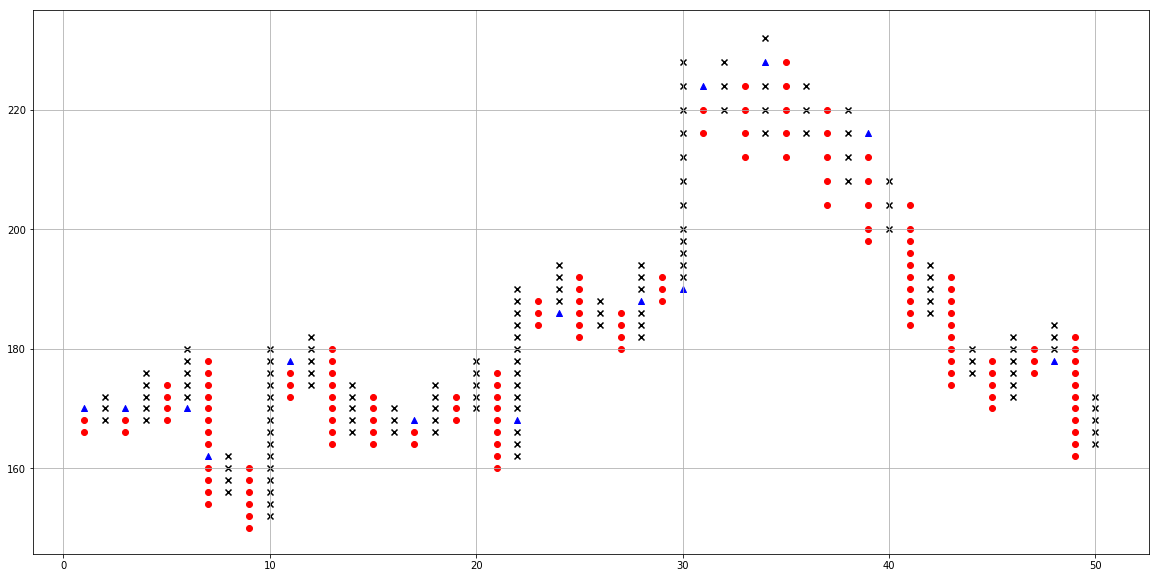

In [15]:
sec.plot_chart()

# Use PnF Data to Generate Bars

In [16]:
sec.generate_pnf_bars()
sec._pnf_bars.head()

,direction,price,timedelta
date,,,
2017-11-29,o,166.0,0 days
2017-11-30,x,172.0,1 days
2017-12-06,o,166.0,6 days
2017-12-11,x,172.0,5 days
2017-12-15,x,174.0,4 days
